In [1]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_ta as ta
import seaborn as sns

/home/sukrit/miniconda3/envs/trading-analysis/lib/python3.11/site-packages/pandas_ta/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
font = {'size': 16}
plt.rc('font', **font)

In [3]:
# ฟังก์ชันตรวจจับ Drip และบันทึก RSI
def detect_drip_with_rsi(data, window=12, threshold=-0.05):
    drips = []
    for i in range(len(data) - window):
        if drips and (data.index[i] - drips[-1]['start_time']).total_seconds() / 3600 < window:
            continue  # ข้ามถ้า Drip ใหม่เริ่มภายใน 12 ชั่วโมงจาก Drip ก่อนหน้า
        
        close_price = data['close'].iloc[i]
        low_price = data['low'].iloc[i:i+window].min()
        drip_pct = (low_price - close_price) / close_price
        if drip_pct <= threshold:
            rsi_at_start = data['RSI_14'].iloc[i]
            drips.append({
                'start_time': data.index[i],
                'close_price': close_price,
                'low_price': low_price,
                'drip_pct': drip_pct * 100,
                'rsi_at_start': rsi_at_start,
                'month': data.index[i].month
            })
            # ข้าม 12 ชั่วโมงเพื่อลด Overlap
            i += window - 1
    return pd.DataFrame(drips)

In [4]:
data = pd.read_pickle(os.path.abspath("../datasets/processed/1h/BTCUSDT.pkl"))
data['RSI_14'] = ta.rsi(data['close'], length=14)

# ตรวจจับ Drip และบันทึก RSI
drips = detect_drip_with_rsi(data)

In [5]:
# 1. การแจกแจงของ RSI ขณะเริ่ม Drip
print("\nSummary of RSI at Drip Start:")
rsi_summary = {
    'Number of Drips': len(drips),
    'Mean RSI': drips['rsi_at_start'].mean(),
    'Std RSI': drips['rsi_at_start'].std(),
    'Min RSI': drips['rsi_at_start'].min(),
    'Max RSI': drips['rsi_at_start'].max(),
    'Median RSI': drips['rsi_at_start'].median()
}
for key, value in rsi_summary.items():
    print(f"{key}: {value:.2f}")



Summary of RSI at Drip Start:
Number of Drips: 711.00
Mean RSI: 51.97
Std RSI: 15.30
Min RSI: 4.37
Max RSI: 94.66
Median RSI: 51.45


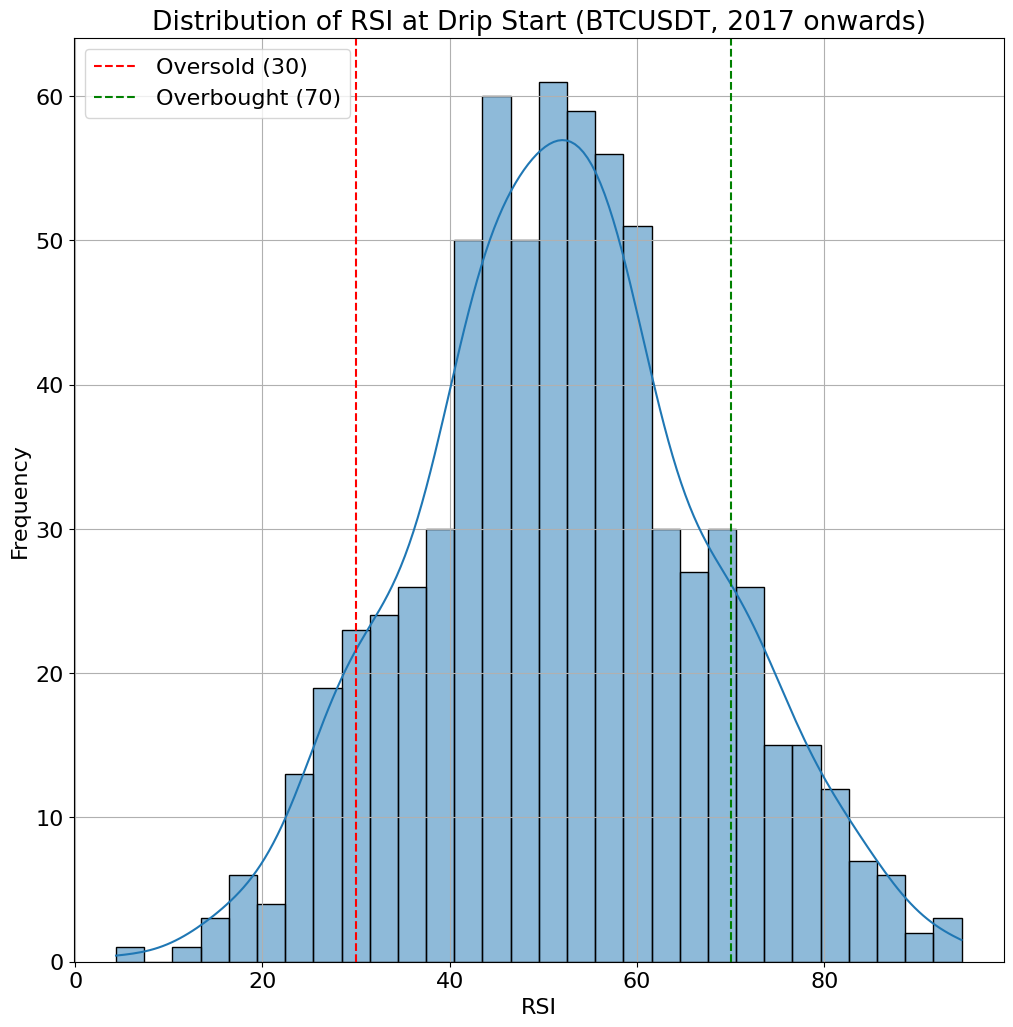

In [6]:
# สร้างฮิสโตแกรมของ RSI
plt.figure(figsize=(12, 12))
sns.histplot(drips['rsi_at_start'].dropna(), bins=30, kde=True)
plt.title('Distribution of RSI at Drip Start (BTCUSDT, 2017 onwards)')
plt.xlabel('RSI')
plt.ylabel('Frequency')
plt.axvline(30, color='r', linestyle='--', label='Oversold (30)')
plt.axvline(70, color='g', linestyle='--', label='Overbought (70)')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# ทดสอบความปกติของ RSI (Shapiro-Wilk Test)
stat, p_value = stats.shapiro(drips['rsi_at_start'].dropna())
print(f"\nShapiro-Wilk Test for RSI Normality: stat={stat:.4f}, p-value={p_value:.4f}")
if p_value < 0.05:
    print("RSI distribution is not normal (p < 0.05)")
else:
    print("RSI distribution is normal (p >= 0.05)")


Shapiro-Wilk Test for RSI Normality: stat=0.9975, p-value=0.3692
RSI distribution is normal (p >= 0.05)


In [8]:
# 2. ค่าเฉลี่ย RSI ตามเดือน
monthly_rsi_means = drips.groupby('month')['rsi_at_start'].mean().reset_index()
monthly_rsi_means.columns = ['Month', 'Mean RSI']
print("\nMean RSI at Drip Start by Month:")
print(monthly_rsi_means.round(2))


Mean RSI at Drip Start by Month:
    Month  Mean RSI
0       1     52.39
1       2     54.14
2       3     48.22
3       4     58.71
4       5     50.74
5       6     48.62
6       7     54.83
7       8     51.73
8       9     46.71
9      10     59.52
10     11     49.83
11     12     54.57


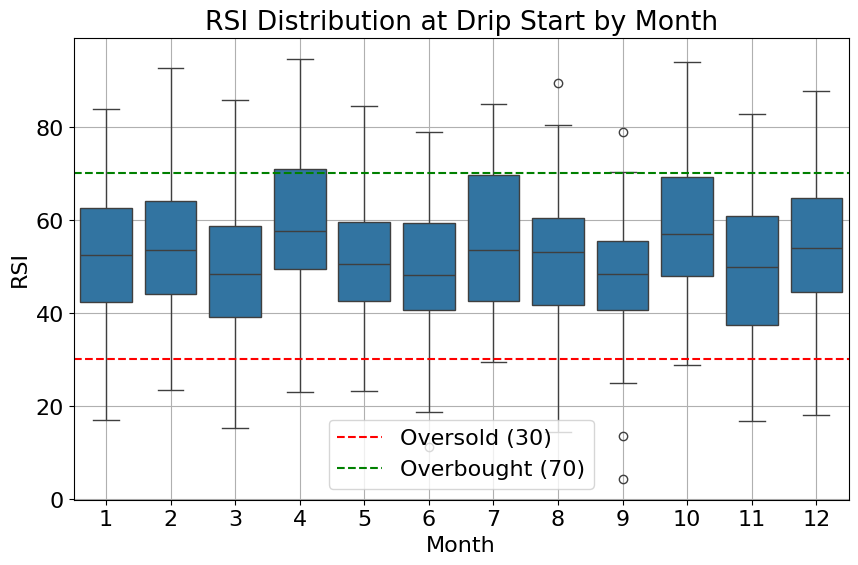

In [9]:
# สร้าง Boxplot เพื่อแสดงการกระจายของ RSI ตามเดือน
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='rsi_at_start', data=drips)
plt.title('RSI Distribution at Drip Start by Month')
plt.xlabel('Month')
plt.ylabel('RSI')
plt.axhline(30, color='r', linestyle='--', label='Oversold (30)')
plt.axhline(70, color='g', linestyle='--', label='Overbought (70)')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# 3. T-Test: เปรียบเทียบค่าเฉลี่ย RSI ระหว่างคู่เดือน
print("\nT-Test Results for RSI (p-values for pairwise comparisons):")
t_test_results = []
month_pairs = list(itertools.combinations(drips['month'].unique(), 2))
for month1, month2 in month_pairs:
    group1 = drips[drips['month'] == month1]['rsi_at_start'].dropna()
    group2 = drips[drips['month'] == month2]['rsi_at_start'].dropna()
    if len(group1) > 1 and len(group2) > 1:
        t_stat, p_value = stats.ttest_ind(group1, group2)
        t_test_results.append({
            'Month Pair': f'{month1} vs {month2}',
            'T-Statistic': t_stat,
            'P-Value': p_value
        })
t_test_df = pd.DataFrame(t_test_results)
print(t_test_df.round(4))


T-Test Results for RSI (p-values for pairwise comparisons):
   Month Pair  T-Statistic  P-Value
0      8 vs 9       1.6208   0.1086
1     8 vs 10      -1.9017   0.0617
2     8 vs 11       0.5772   0.5650
3     8 vs 12      -1.0294   0.3053
4      8 vs 1      -0.2390   0.8115
..        ...          ...      ...
61     4 vs 6       3.2502   0.0015
62     4 vs 7       1.0404   0.3014
63     5 vs 6       0.8429   0.4009
64     5 vs 7      -1.3657   0.1752
65     6 vs 7      -1.8897   0.0619

[66 rows x 3 columns]


In [11]:
# 4. Tukey’s HSD Test: เปรียบเทียบค่าเฉลี่ย RSI ระหว่างทุกเดือน
if len(drips['month'].unique()) > 2:
    tukey = pairwise_tukeyhsd(endog=drips['rsi_at_start'].dropna(), groups=drips['month'], alpha=0.05)
    print("\nTukey’s HSD Test Results for RSI:")
    print(tukey.summary())
else:
    print("\nTukey’s HSD Test: Not enough months to perform the test.")

ValueError: data has 710 elements and groups has 711